In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from astropy.io import ascii
from scipy import interpolate
import emcee

In [2]:
all_dr25 = pd.read_csv("result.csv")
selected_stars = all_dr25.where((all_dr25["log(g)"]>4)&(all_dr25["Mass"]<1.2)&(all_dr25["Mass"]>0.8)).dropna(how='all')

data = ascii.read("nph-nstedAPI.txt")  
all_stars = data.to_pandas()
all_stars_in_selected_stars = all_stars[all_stars['kepid'].isin(selected_stars["KIC"])]
all_stars_in_selected_stars = all_stars_in_selected_stars[~np.isnan(all_stars_in_selected_stars["rrmscdpp06p0"])]

In [7]:
observation, _ = np.histogram(all_stars_in_selected_stars["nconfp"],bins = range(0,12))
N = np.sum(observation)
observation = torch.Tensor(observation)
# y = torch.load("sims/data_y_mult_hist_fixstars_all")/N
# x = torch.load("sims/data_x_params_fixstars_all")

import glob

x = torch.zeros((0,7))
y = torch.zeros((0,11))

for i in glob.glob("simulations_etazero/data_x*"):
    run_label = i[34:]
    xnew = torch.load(i)
    ynew = torch.load("simulations_etazero/data_y_mult_hist_"+run_label)
    x = torch.concatenate((x,xnew),dim=0)
    y = torch.concatenate((y,ynew),dim=0)

#torch.save(x,"all_sims_x")
#torch.save(y,"all_sims_y")

print(x.shape)
valid_indices = torch.where(torch.sum(y,dim=1)>=108013)
invalid_indices = torch.where(torch.sum(y,dim=1)<108013)

x_invalid = x[invalid_indices]

x = x[valid_indices]
y = y[valid_indices]

print(x.shape)

norm_factor = (torch.max(x,dim=0)[0])



torch.Size([3742, 7])
torch.Size([1281, 7])


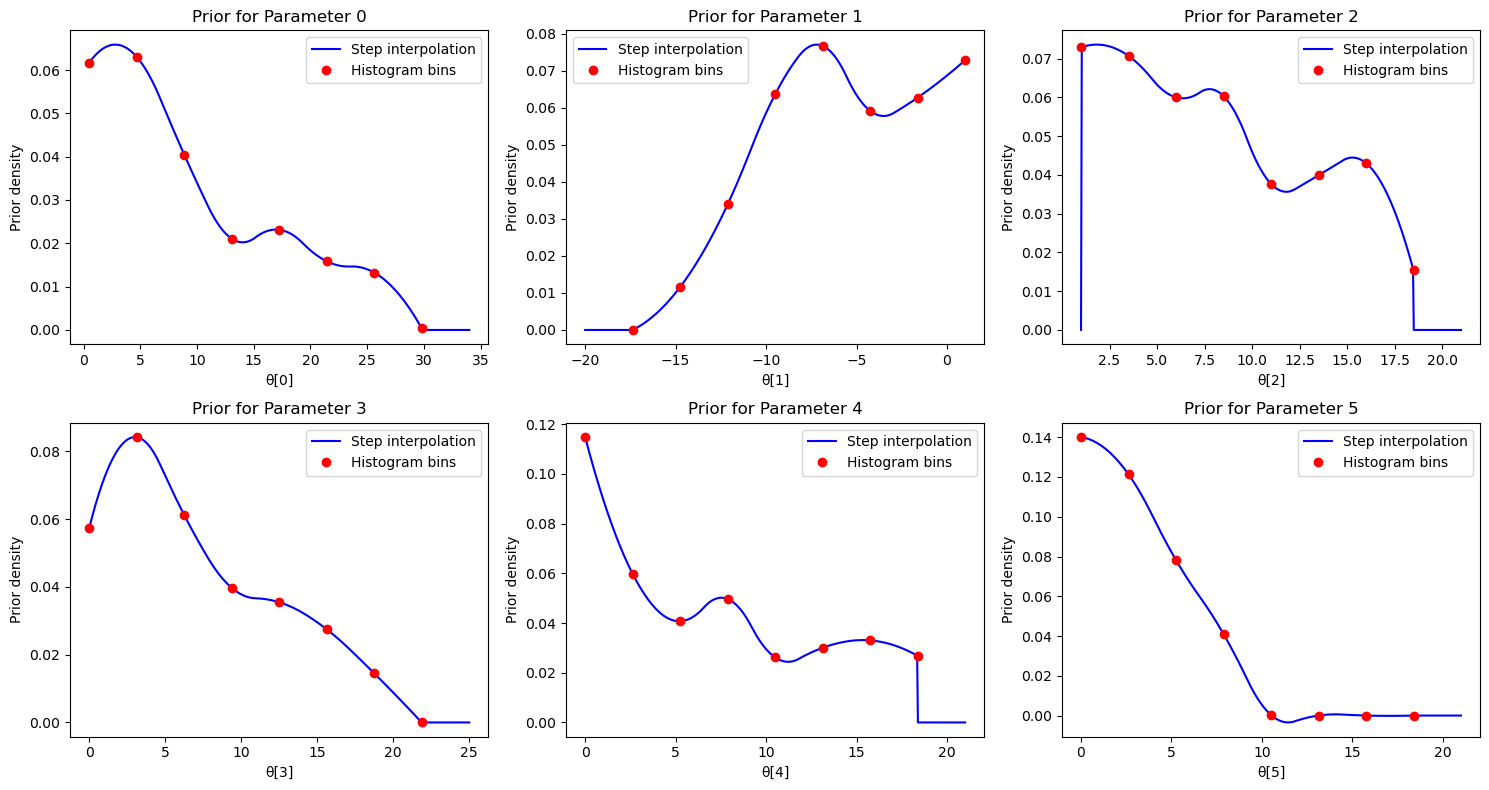

In [8]:
ranges = np.array([
    [0.5, 34],
    [-20, 0.999],
    [1.0001, 21],
    [0, 25],
    [0, 21],
    [0, 21],
    [0, 1.1]
])

pdf_interp_list = []

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(6):
    #bin_edges = np.linspace(start=ranges[i][0], stop=ranges[i][1], num=8)
    counts, bin_edges = np.histogram(x[:,i].numpy(), bins=8, range=ranges[i])
    bin_widths = np.diff(bin_edges)

    # PDF = counts normalized over full width
    pdf = counts / np.sum(counts) / bin_widths

    # Clip tiny values
    #pdf = np.clip(pdf, 1e-300, np.inf)
    # Interpolator: step function between bins
    if i == 1:
        interp = interpolate.interp1d(
        bin_edges[1:], pdf,
        kind=2,     
        bounds_error=False,
        fill_value=0.0)
        ax = axes[i]
        theta_grid = np.linspace(ranges[i,0], ranges[i,1], 500)
        ax.plot(theta_grid, interp(theta_grid), label='Step interpolation', color='b')
        ax.plot(bin_edges[1:], pdf, 'ro', label='Histogram bins')

    else:
        interp = interpolate.interp1d(
            bin_edges[:-1], pdf,
            kind=2,     
            bounds_error=False,
            fill_value=0.0)
        ax = axes[i]
        theta_grid = np.linspace(ranges[i,0], ranges[i,1], 500)
        ax.plot(theta_grid, interp(theta_grid), label='Step interpolation', color='b')
        ax.plot(bin_edges[:-1], pdf, 'ro', label='Histogram bins')
        
    pdf_interp_list.append(interp)

    # Plot
    
    ax.set_xlabel(f'θ[{i}]')
    ax.set_ylabel('Prior density')
    ax.set_title(f'Prior for Parameter {i}')
    ax.legend()

plt.tight_layout()
plt.show()



In [9]:

class Emulator(nn.Module):
    def __init__(self):
        super(Emulator, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(6, 64)     # First hidden layer (input: 5 units, output: 64 units)
        self.fc2 = nn.Linear(64, 128)   # Second hidden layer (input: 64 units, output: 128 units)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)   # Output layer (input: 128 units, output: 33 units)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 11)
                             
        # Activation function
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # Pass through the layers with activation
        x = self.relu(self.fc1(x))      # Input to first layer and activation
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)      # Second layer and activation
        x = self.relu(self.fc3(x) )
        x = self.dropout(x)
        x = self.relu(self.fc4(x) )
        x = self.dropout(x)
        x = self.relu(self.fc5(x) )
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.log_softmax(self.fc7(x))        # Output layer (no activation if regression task)
        
        # logits_10 = self.fc7(x)  # 10 logits from the network
        # logit_0 = -torch.exp(torch.logsumexp(logits_10,1,keepdim=True))
    
        # logits_all = torch.cat([logit_0, logits_10], dim=-1)  # Concatenate with the 11th bin
        # log_probs = torch.log_softmax(logits_all, dim=-1)

        return x


model = Emulator()

model.eval()
model.load_state_dict(torch.load("best_model_0to10", weights_only=True))


<All keys matched successfully>

In [10]:
@torch.no_grad()
def log_like(theta):
    theta_tensor = torch.as_tensor(theta[:-1], dtype=torch.float32)
    eta = torch.as_tensor(theta[-1], dtype=torch.float32)
    if eta >= 1.0:
        return -np.inf
    else:
        log_probs = model(theta_tensor / norm_factor[:-1]) + torch.log(1. - eta)
        if eta != 0.0:
            log_probs[0] = torch.logaddexp(torch.log(eta), log_probs[0])
        return torch.sum(observation * log_probs).item()
    #return 0.0

# def log_prior(theta):
#     rcrit, alpha_small, alpha_big, sigma, sigma_i, b, eta = theta
#     logp = 0.0

#     if 0.5 < rcrit < 30:
#         logp += -np.log(rcrit)
#     else:
#         return -np.inf

#     if not (-15 < alpha_small < 1):
#         return -np.inf

#     if not (1 < alpha_big < 20): 
#         return -np.inf

#     if 0 < sigma < 20:
#         logp += -np.log(sigma)
#     else:
#         return -np.inf

#     if not (0 < sigma_i < 20):
#         return -np.inf

#     if not (0 < b < 12):
#         return -np.inf
        
#     if not (0 < eta < 1):
#         return -np.inf

#     return logp


def log_prior(theta):
    lp = 0.0
    for i in range(6):
        p = pdf_interp_list[i](theta[i])
        if not np.isfinite(p):
            return -np.inf
        if p <= 0:
            return -np.inf
        lp += np.log(p)
    if theta[-1] > 1:
        return -np.inf
    if theta[-1] < 0:
        return -np.inf
    return lp


def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(theta)



In [12]:
ndim = 7  # Number of parameters
nwalkers = 4 * ndim  # Recommended: 2-4 times ndim
nsteps = 20000
chunk_size = 1000  # Save every N steps
nchunks = nsteps // chunk_size
output_file = "mcmc_chain.h5"

backend = emcee.backends.HDFBackend(output_file)
backend.reset(nwalkers, ndim) 

p0 = np.random.uniform(
    low=[5, -0.8, 1.1, 5, 1, 7, 0.7],  # Lower bounds
    high=[6, -0.9, 1.2, 6, 2, 8, 0.8],  # Upper bounds
    size=(nwalkers, ndim)
)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,backend=backend)

for i in range(nchunks):
    print(f"Running chunk {i+1}/{nchunks}...")
    sampler.run_mcmc(p0, chunk_size, progress=True)
    p0 = sampler.get_last_sample().coords
    print(f"Saved chunk {i+1} to {output_file}")


Running chunk 1/20...


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:11<00:00, 84.11it/s]


Saved chunk 1 to mcmc_chain.h5
Running chunk 2/20...


100%|██████████| 1000/1000 [00:10<00:00, 95.14it/s]


Saved chunk 2 to mcmc_chain.h5
Running chunk 3/20...


100%|██████████| 1000/1000 [00:10<00:00, 96.61it/s]


Saved chunk 3 to mcmc_chain.h5
Running chunk 4/20...


100%|██████████| 1000/1000 [00:09<00:00, 104.31it/s]


Saved chunk 4 to mcmc_chain.h5
Running chunk 5/20...


100%|██████████| 1000/1000 [00:09<00:00, 102.95it/s]


Saved chunk 5 to mcmc_chain.h5
Running chunk 6/20...


100%|██████████| 1000/1000 [00:11<00:00, 89.68it/s]


Saved chunk 6 to mcmc_chain.h5
Running chunk 7/20...


100%|██████████| 1000/1000 [00:11<00:00, 83.37it/s]


Saved chunk 7 to mcmc_chain.h5
Running chunk 8/20...


100%|██████████| 1000/1000 [00:11<00:00, 89.72it/s]


Saved chunk 8 to mcmc_chain.h5
Running chunk 9/20...


100%|██████████| 1000/1000 [00:10<00:00, 92.27it/s]


Saved chunk 9 to mcmc_chain.h5
Running chunk 10/20...


100%|██████████| 1000/1000 [00:10<00:00, 95.97it/s]


Saved chunk 10 to mcmc_chain.h5
Running chunk 11/20...


100%|██████████| 1000/1000 [00:10<00:00, 92.53it/s]


Saved chunk 11 to mcmc_chain.h5
Running chunk 12/20...


100%|██████████| 1000/1000 [00:10<00:00, 96.00it/s]


Saved chunk 12 to mcmc_chain.h5
Running chunk 13/20...


100%|██████████| 1000/1000 [00:09<00:00, 100.13it/s]


Saved chunk 13 to mcmc_chain.h5
Running chunk 14/20...


100%|██████████| 1000/1000 [00:10<00:00, 95.91it/s]


Saved chunk 14 to mcmc_chain.h5
Running chunk 15/20...


100%|██████████| 1000/1000 [00:10<00:00, 94.14it/s]


Saved chunk 15 to mcmc_chain.h5
Running chunk 16/20...


100%|██████████| 1000/1000 [00:09<00:00, 100.62it/s]


Saved chunk 16 to mcmc_chain.h5
Running chunk 17/20...


100%|██████████| 1000/1000 [00:10<00:00, 99.59it/s]


Saved chunk 17 to mcmc_chain.h5
Running chunk 18/20...


100%|██████████| 1000/1000 [00:10<00:00, 97.50it/s]


Saved chunk 18 to mcmc_chain.h5
Running chunk 19/20...


100%|██████████| 1000/1000 [00:10<00:00, 98.70it/s]


Saved chunk 19 to mcmc_chain.h5
Running chunk 20/20...


100%|██████████| 1000/1000 [00:10<00:00, 97.48it/s]

Saved chunk 20 to mcmc_chain.h5


In [14]:
# Run after crash
backend = emcee.backends.HDFBackend(output_file)

last_sample = backend.get_last_sample()
p0 = last_sample.coords

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, backend=backend)

steps_remaining = nsteps - backend.iteration

for i in range(steps_remaining // chunk_size):
    print(f"Resuming: chunk {i+1}")
    sampler.run_mcmc(p0, chunk_size, progress=True)
    p0 = sampler.get_last_sample().coords


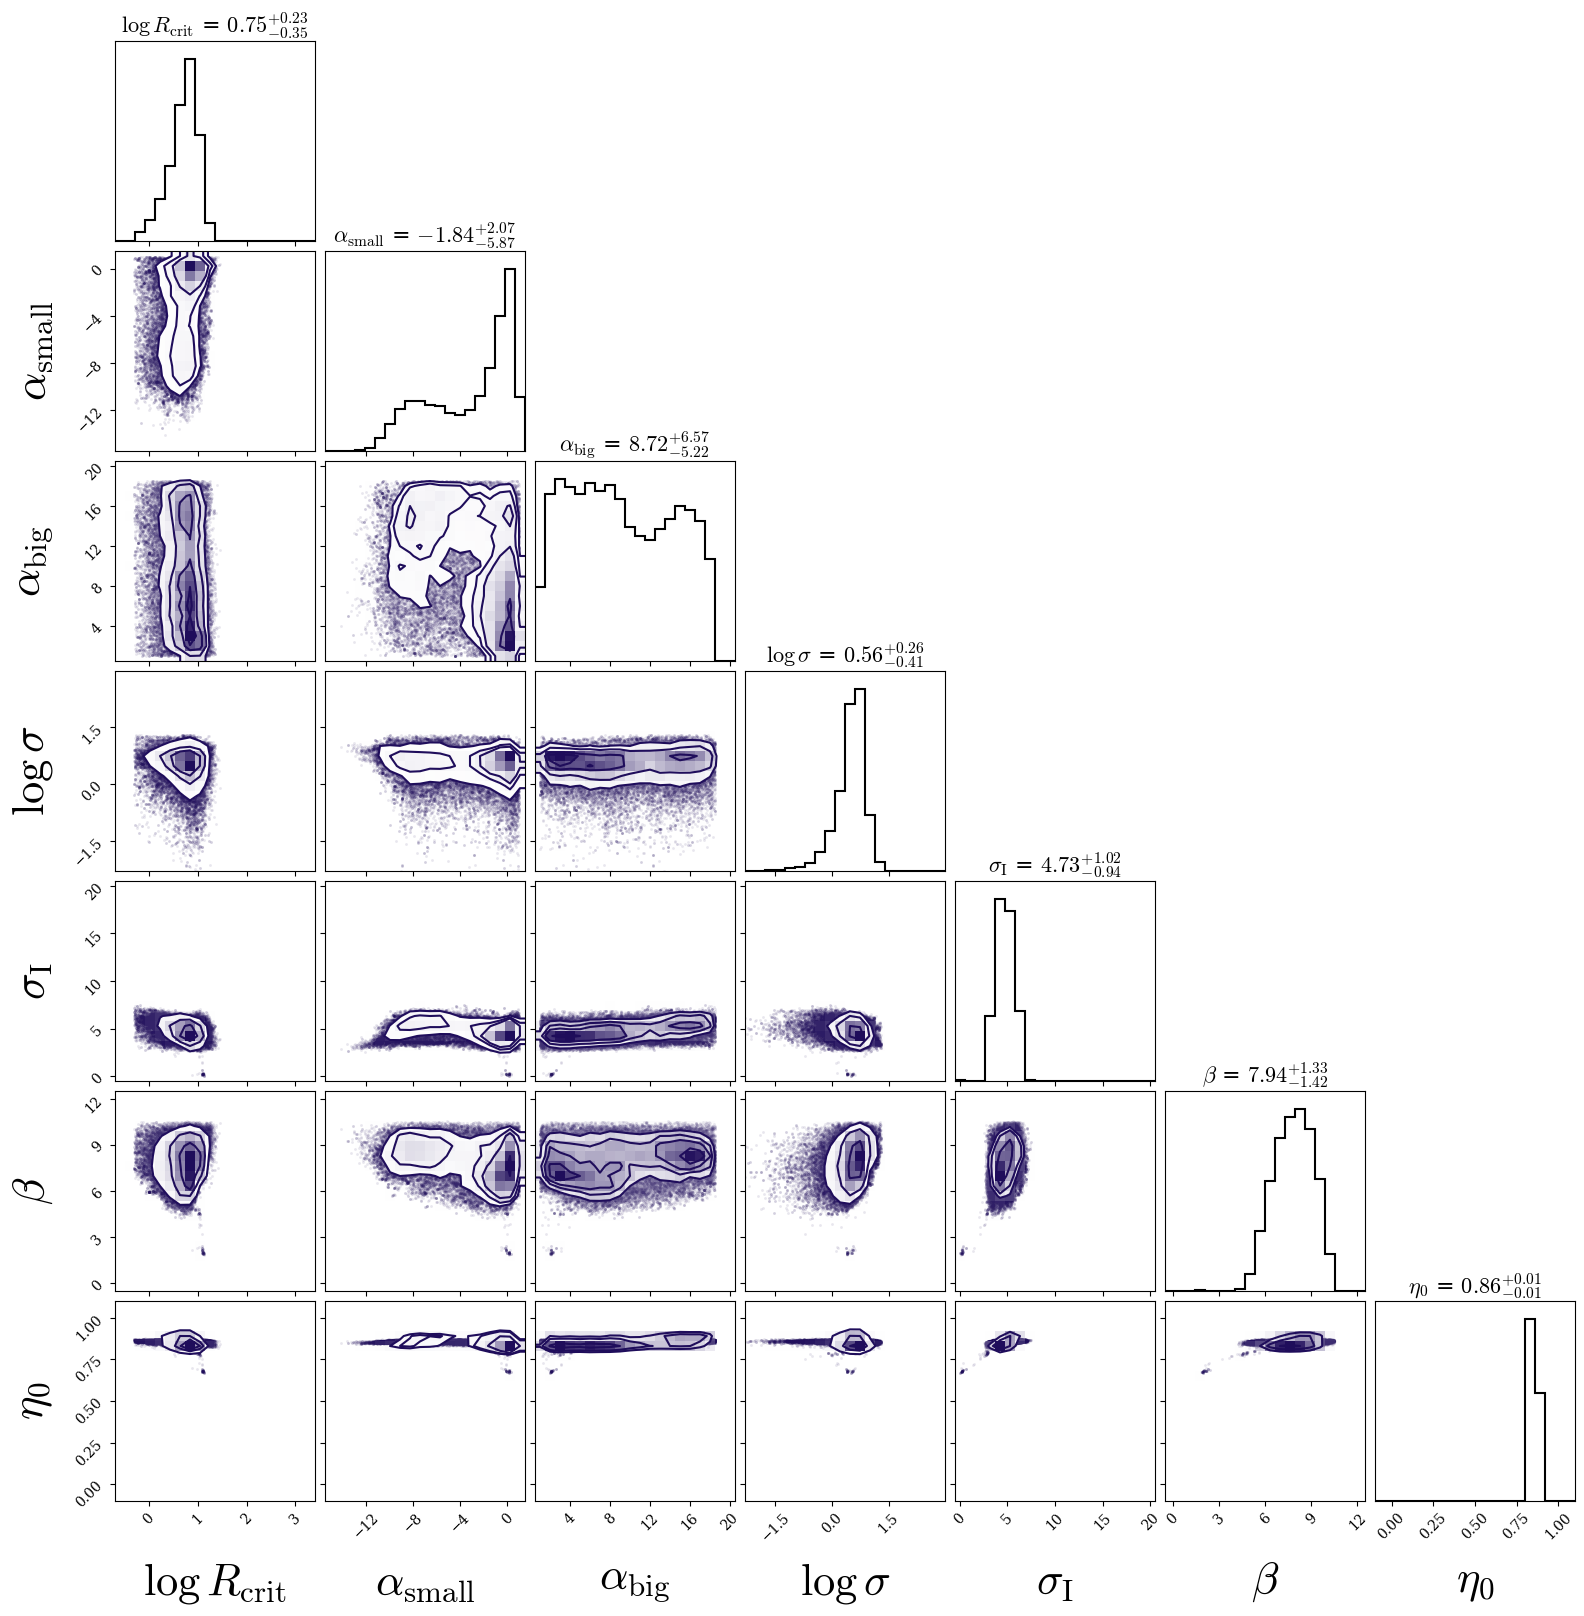

In [13]:
import matplotlib.pyplot as plt
import corner
import numpy as np
from matplotlib import rcParams

rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm", 
    "text.latex.preamble": r'\usepackage{cmunitx}'
})

output_file = "mcmc_chain.h5"
backend = emcee.backends.HDFBackend(output_file)
samples = backend.get_chain(discard=100, thin=10, flat=True)
#samples = sampler.get_chain(discard=100, thin=10, flat=True)

samples_logplot = np.copy(samples)
samples_logplot[:, 0] = np.log10(samples_logplot[:, 0])  # log10(R_crit)
samples_logplot[:, 3] = np.log10(samples_logplot[:, 3])  # log10(sigma)

labels = [
    r"$\log R_{\text{crit}}$", 
    r"$\alpha_{\text{small}}$", 
    r"$\alpha_{\text{big}}$", 
    r"$\log \sigma$", 
    r"$\sigma_\text{I}$", 
    r"$\beta$", 
    r"$\eta_{0}$"
]

prior_ranges = [
    [np.log(0.5), np.log(30)],
    [-15.5, 1.5],                     
    [0.5, 20.5],                    
    [np.log(0.1), np.log(20)],  
    [-0.5, 20.5],                 
    [-0.5, 12.5],              
    [-0.1, 1.1],              
]

# Plot corner plot
fig = corner.corner(
    samples_logplot, 
    labels=labels, 
    color="#1f0d5b", 
    alpha=0.9, 
    show_titles=True, 
    range=prior_ranges,
    title_kwargs={"fontsize": 16}, 
    label_kwargs={"fontsize": 32}, 
    hist_kwargs={
        "color": "black",
        "fill": False,
        "linewidth": 1.5,
    },
    tick_kwargs={"labelsize": 14}
)

theta_median = np.median(samples, axis=0)
theta_std = np.std(samples, axis=0)

# print("Best-fit parameters:")
# for i, (median, std) in enumerate(zip(theta_median, theta_std)):
#     print(f"Theta {i+1}: {median:.3f} ± {std:.3f}")

plt.savefig("corner_plot.png", bbox_inches="tight")



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the full chain (shape: nsteps, nwalkers, ndim)
chain = sampler.get_chain()

# Number of parameters
ndim = chain.shape[-1]

fig, axes = plt.subplots(ndim, figsize=(10, 2 * ndim), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(chain[::2, ::8, i], alpha=0.5)  # Plot each walker
    ax.set_ylabel(f"{labels[i]}")
    ax.set_ylim(prior_ranges[i])  # Set y-limits from prior
    ax.axvline(x=100, color='r', linestyle='--', label="Burn-in (100 steps)")
    ax.legend()

axes[-1].set_xlabel("Step Number")
plt.suptitle("MCMC Chains for Each Parameter")
plt.show()


In [ ]:
np.save("emcee_params.npy",samples[::2000])
samples[::2000].shape

In [ ]:
sim_files_y = glob.glob("all_posterior_samples/data_y*")
sim_files_x = glob.glob("all_posterior_samples/data_x*")

sim_ys = []
sim_ys_v2 = []
sim_ys_v3 = []
sim_xs = []

ems_y = []

for i, sim in enumerate(sim_files_y):
    if torch.sum(torch.load(sim)[0]) > 108013:
        if sim[-2:] == "v2":
            sim_ys_v2.append(torch.load(sim_files_y[i])[0])
        elif sim[-2:] == "v3":
            sim_ys_v3.append(torch.load(sim_files_y[i])[0])
        else:
            sim_ys.append(torch.load(sim_files_y[i])[0])
            theta = torch.load(sim_files_x[i])[0]
            sim_xs.append(theta)
            eta = torch.Tensor([theta[-1]])
            em = model(theta[:-1] / norm_factor[:-1]) + torch.log(1. - eta)
            if eta != 0.0:
                em[0] = torch.logaddexp(torch.log(eta), em[0])
            ems_y.append(em.detach().numpy())

sim_ys = np.array(sim_ys)
sim_ys_v2 = np.array(sim_ys_v2)
sim_ys_v3 = np.array(sim_ys_v3)
sim_xs = np.array(sim_xs)
ems_y = np.array(ems_y)

ems_y = np.exp(ems_y)*N
ems_y[ems_y<1/(np.e)] = 1/(np.e)
em_err = ems_y**0.5

sim_ys[sim_ys==0.0] = 1/(np.e)
sim_ys_v2[sim_ys_v2==0.0] = 1/(np.e)
sim_ys_v2[sim_ys_v2==0.0] = 1/(np.e)

n_plots = len(sim_ys)

ncols = 3
nrows = int(np.ceil(n_plots / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows), sharex=True)

# Flatten the 2D array of axes to make it easier to iterate
axs = axs.flatten()

for i, y in enumerate(sim_ys):
    ax = axs[i]
    ax.semilogy(range(0, 11), observation, "x", markersize=15, color="black", label="observation")
    ax.errorbar(range(0, 11), ems_y[i], yerr=em_err[i], fmt="+", markersize=10, capsize=5, color="blue", label="emulated")
    ax.semilogy(range(0, 11), sim_ys[i], "^", markersize=7, color="red", label="simulated")
    ax.semilogy(range(0, 11), sim_ys_v2[i], "^", markersize=7, color="red")
    ax.semilogy(range(0, 11), sim_ys_v3[i], "^", markersize=7, color="red")

    ax.set_ylabel("Count (log scale)")
    ax.legend()

# Turn off any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Set x-label on bottom row only
for ax in axs[-ncols:]:
    ax.set_xlabel("Multiplicity")

#plt.title("Em vs Sim from Sampled Posterior")
plt.tight_layout()
plt.show()
